In [ ]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q


In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tensorflow.keras.models import Sequential

import nltk
import emoji
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import gensim
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# TODO: Load read and load the data here
# Load the dataset
data = pd.read_csv("/twitter-suicidal-data.csv")  # Replace "twitter-suicide-dataset.csv" with the actual file path

# Preprocess the text data
tweets = data["tweet"].astype(str)  # Convert text column to string type
intentions = data["intention"]
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB


intention
count  9119.000000
mean      0.438425
std       0.496221
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [1]:

def preprocess_data(tweet):

  # Lowercase the tweet
  tweet = tweet.lower()
  # Remove mentions
  tweet = re.sub(r'@\w+', '', tweet)
  # Remove punctuation
  # print(tweet)
  tweet = re.sub(r'[^\w\s]', '', tweet)

  # Remove numbers
  tweet = re.sub(r'\d+', '', tweet)

  # Remove URLs
  tweet = re.sub(r'http\S+', '', tweet)

  # tweet = re.sub(r'<[a-zA-Z]+\s+[a-zA-Z]+>', '', tweet)

  # Remove emojis
  tweet = re.sub(r'[^\w\s]', '', tweet)

  # Normalize whitespace
  tweet = re.sub(r'\s+', ' ', tweet)

  # Remove non-word characters
  tweet = re.sub(r'[^a-zA-Z\s]+', '', tweet)

  # Tokenize
  tokens = tweet.split()

  # Lemmatize
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  # Remove stop words
  stop_words = set(stopwords.words('english'))
  tokens = [token for token in tokens if token not in stop_words]
  # return tweet
  return tokens


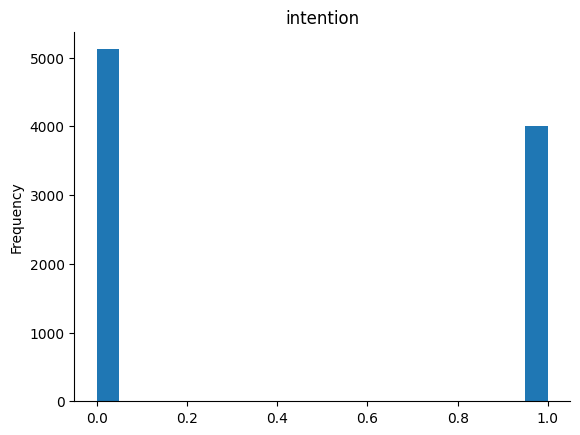

In [ ]:
from matplotlib import pyplot as plt
data['intention'].plot(kind='hist', bins=20, title='intention')
plt.gca().spines[['top', 'right',]].set_visible(False)

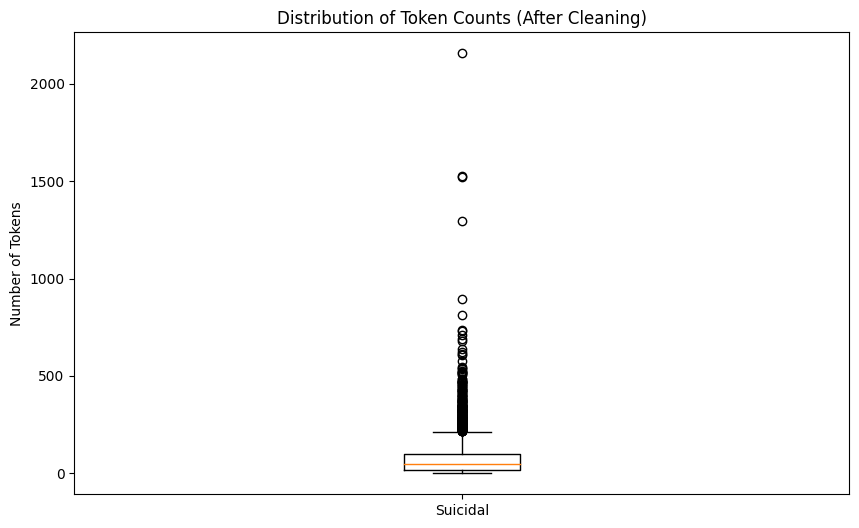

Suicidal Tweet Token Count Statistics:
Min: 0
Max: 2157
Mean: 74.98899449724863


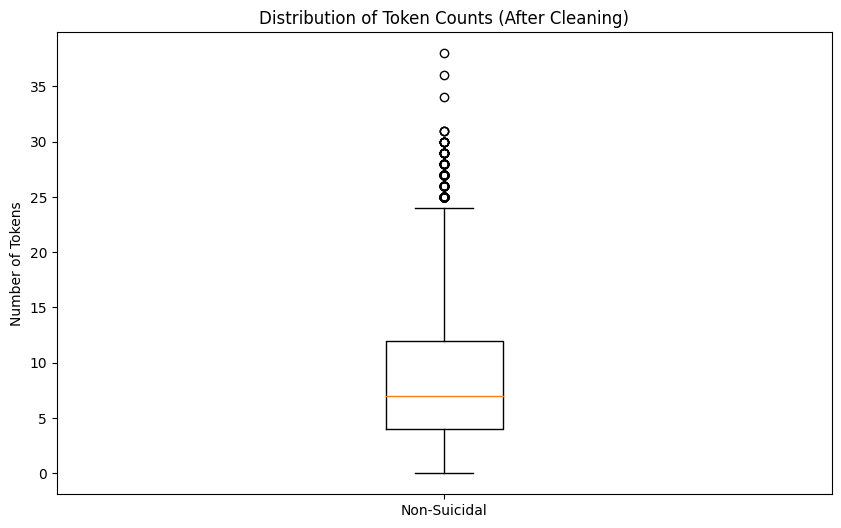

Non-Suicidal Tweet Token Count Statistics:
Min: 0
Max: 38
Mean: 9.048428041398164
------------------------------


In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([ suicidal_token_counts], labels=[ "Suicidal"])#non_suicidal_token_counts,"Non-Suicidal",
plt.title("Distribution of Token Counts (After Cleaning)")
plt.ylabel("Number of Tokens")
plt.show()

print("Suicidal Tweet Token Count Statistics:")
print(f"Min: {min(suicidal_token_counts)}")
print(f"Max: {max(suicidal_token_counts)}")
print(f"Mean: {sum(suicidal_token_counts) / len(suicidal_token_counts)}")


plt.figure(figsize=(10, 6))
plt.boxplot([ non_suicidal_token_counts], labels=[ "Non-Suicidal"])#non_suicidal_token_counts,"Non-Suicidal",
plt.title("Distribution of Token Counts (After Cleaning)")
plt.ylabel("Number of Tokens")
plt.show()

# Print statistics
print("Non-Suicidal Tweet Token Count Statistics:")
print(f"Min: {min(non_suicidal_token_counts)}")
print(f"Max: {max(non_suicidal_token_counts)}")
print(f"Mean: {sum(non_suicidal_token_counts) / len(non_suicidal_token_counts)}")
print("-" * 30)

In [ ]:
nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
## TODO: Show some samples before/after preprocessing
cleaned_tweets = []
for i in range(len(tweets)):
  cleaned_tweets.append(preprocess_data(tweets[i]))

In [ ]:
# Analyze token counts
suicidal_token_counts = []
non_suicidal_token_counts = []

for i in  range(len(cleaned_tweets)):
  if intentions[i] == 1:
    suicidal_token_counts.append(len(cleaned_tweets[i]))
  else:
    non_suicidal_token_counts.append(len(cleaned_tweets[i]))

Streaming output truncated to the last 5000 lines.
['still', 'alive', 'lack', 'knowledge', 'heart', 'made', 'miss', 'fatal', 'blow', 'inch', 'away', 'didnt', 'let', 'diei', 'amsick', 'tired', 'people', 'saying', 'got', 'life', 'ahead', 'still', 'young', 'shouldnt', 'kill', 'amjust', 'overeacting', 'heart', 'break', 'well', 'heart', 'break', 'killed', 'inside', 'whats', 'wrong', 'completely', 'dead', 'ive', 'got', 'nothing', 'left', 'inside', 'love', 'funny', 'thing', 'matter', 'hard', 'tell', 'meant', 'alot', 'much', 'tell', 'love', 'would', 'sacrifice', 'everything', 'yet', 'look', 'away', 'like', 'feeling', 'doesnt', 'mean', 'anything', 'hard', 'confess', 'love', 'someone', 'adore', 'everything', 'easy', 'say', 'shot', 'missed', 'certain', 'thing', 'want', 'feeling', 'dying', 'seems', 'alot', 'comforting', 'live', 'one', 'second', 'pathetic', 'life']
88
['anymore', 'sorry', 'placebeen', 'depressed', 'long', 'remember', 'always', 'try', 'smile', 'outside', 'insidei', 'amdead', 'anxiet

In [ ]:
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
import gensim.downloader as api
import gensim.models
import os

W2V_PATH = "/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin"

# Option 1: Load from file (if it exists)
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    try:
        w2v_model = gensim.models.KeyedVectors.load_word2vec_format(W2V_PATH, binary=True)
        print("Word2Vec model is loaded.")
    except Exception as e:
        print(f"Error loading Word2Vec model: {e}")
        print("Downloading Word2Vec model...")
        w2v_model = api.load("word2vec-google-news-300")
        print("Word2vec model is downloaded.")

# Option 2: Download if not found (or load failed)
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
        print("\nSaving Word2Vec model...")
        w2v_model.save(W2V_PATH)
        print("Word2Vec model is saved.")

Loading Word2Vec model...
Error loading Word2Vec model: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2vec model is downloaded.


In [ ]:
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings

In [ ]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size


In [ ]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"
        # print("len",len(self.dataframe))
        # print("dataframe:" , self.dataframe)
        # print("w2v_model:" , self.w2v_model)
        # print("max_sequence_len:" , self.max_sequence_len)
        # print("vector_size:" , self.vector_size)
        # print("df_token_col:" , self.df_token_col)

        self._proc_dataset()

        self.len = len(self.dataframe)
        # print("len:" , self.len)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        # print(self.dataframe[self.df_token_col])
        print(self.df_token_col)
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
      # TODO: Return a 2D tensor for whole list of tokens, using vectors from w2v as explained on the description
        matrix = []
        for token in tokens:
          if token in self.w2v_model:
            matrix.append(self.w2v_model[token])
          else:
            matrix.append(np.zeros(self.vector_size))
        return torch.tensor(matrix, dtype=torch.float32)
    def _pad(self, tokens: list):
        # TODO: Add paddings (zero-vectors) into the end of sequence to reach the desired length
        padding_len = self.max_sequence_len - len(tokens)
        if padding_len > 0:
          tokens.extend([0] * padding_len)
        else:
          tokens = tokens[0:64]
        return tokens
    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        print(all_tokens)
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

In [ ]:
from sklearn.model_selection import train_test_split
# TODO: Split dataset into train-test split
X_train, X_test= train_test_split(#, y_train, y_test
    data,
    # data["intention"],
    test_size=0.2,
    random_state=84
)

In [ ]:
# TODO: create twitter dataset
train_dataset = Twitter(
    dataframe=X_train,  # Replace with your train dataframe
    w2v_model=w2v_model,  # Replace with your Word2Vec model
    sequence_len=64 # Replace with your desired maximum sequence length
)
valid_dataset = Twitter(
        dataframe=X_test,  # Replace with your validation dataframe
    w2v_model=w2v_model,  # Same Word2Vec model as for training
    sequence_len=64
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

tokens
Deleted 0-Len Samples: 27


<ipython-input-25-3f8ea8f5d511>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-25-3f8ea8f5d511>:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(matrix, dtype=torch.float32)
<ipython-input-25-3f8ea8f5d511>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

tokens
Deleted 0-Len Samples: 9


<ipython-input-25-3f8ea8f5d511>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)


Train dataset length: 7268
Valid dataset length: 1815


<ipython-input-25-3f8ea8f5d511>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [ ]:
from typing import Union
from typing import List

@torch.no_grad()
def model_eval(model, loader, loss_function, device):#str['cuda', 'cpu', 'auto']
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # TODO: move model's inputs to `device`
        inputs = inputs.to(device)
        labels = labels.to(device)

        # TODO: use model's forward pass to generate outputs
        outputs = model(inputs)

        # TODO: calculate model's loss
        loss = loss_function(outputs, labels)

        # TODO: calculate/update model's accuracy
        _, predicted = torch.max(outputs.data, 1)
        test_acc += (predicted == labels).sum().item()
        test_loss += loss.item() * inputs.size(0)

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc / len(loader.dataset), 5),
        )

    return test_loss, test_acc / len(loader.dataset)

In [ ]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device,
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # TODO: create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    model.to(device)

    itr = tqdm(train_loader, total=len(train_loader), leave=False)
    print(itr)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        print("epoch:",epoch)
        for idx, (inputs, labels) in enumerate(itr, start=1):#itr
            print(idx)
            # TODO: move model's inputs to `device`
            inputs = inputs.to(device)
            labels = labels.to(device)

            # TODO: use model's forward pass to generate outputs
            outputs = model(inputs)

            # TODO: process model's predictipns and calculate/update accuracy
            _, preds = torch.max(outputs, 1)
            epoch_acc += torch.sum(preds == labels.data)

            # TODO: calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()

            # TODO: 1. clear optimizer's state and zero prev grads,
            # TODO: 2. backward calculated loss
            # TODO: 3. step optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
              loss=round(loss.item(), 5),
              accuracy=round(epoch_acc / len(train_loader.dataset), 5),
              )

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
            )

        # TODO: update statistics regaurding model's loss and acc in training or validation phases
        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(epoch_acc / len(train_loader.dataset))

        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [ ]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [ ]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    labels = []
    predicted = []

    model.eval()
    for idx, (inputs, label) in enumerate(itr, start=1):
        # TODO: move model's inputs to `device`
        inputs = inputs.to(device)

        # TODO: use model's forward pass to generate outputs
        outputs = model(inputs)

        # TODO: process model's predictions and save them
        _, preds = torch.max(outputs, 1)
        predicted.extend(preds.cpu().numpy())
        labels.extend(label.cpu().numpy())

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}

In [ ]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x

In [ ]:
model = CNN(input_channels=1, num_classes=10)
print(model)


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Converting text to lowercase
Converting text to lowercase is a common preprocessing step in text analysis and natural language processing (NLP). Here are the advantages and disadvantages of this process:

Advantages:

Consistency: It ensures consistency in the text data, as it eliminates variations due to case differences. For example, “Word” and “word” are treated as the same word after conversion.

Simplification: It simplifies the dataset by reducing the vocabulary size. This is because uppercase and lowercase versions of the same word are no longer considered distinct.

Improved Matching: It aids in matching and searching operations, as queries do not need to account for case variations.

Standardization: Lowercasing is a form of normalization that helps standardize text data, which is beneficial for many NLP tasks like sentiment analysis, topic modeling, and information retrieval.

Disadvantages:

Loss of Information: Some semantic information can be lost, such as the distinction between proper nouns and common nouns (e.g., “Apple” the company vs. “apple” the fruit).

Ambiguity: It can introduce ambiguity, as acronyms and initialisms lose their distinctiveness (e.g., “US” for United States vs. “us”).

Contextual Meaning: The meaning of some words can be context-dependent, and lowercasing can obscure this (e.g., “Polish” a nationality vs. “polish” a verb).

Why Do We Do This Processing? We convert text to lowercase to simplify and standardize the text data for computational processing. It helps algorithms focus on the semantic meaning of the words rather than their form. This preprocessing step is particularly useful when building models that rely on word frequency and distribution, as it reduces complexity and computational cost. However, it’s important to consider the context and the specific requirements of the task at hand to decide whether lowercasing is appropriate.

## Removing numbers
Removing numbers from text data is another preprocessing step in text analysis and natural language processing (NLP). Here are the advantages and disadvantages of this process:

Advantages:

Focus on Text: It helps the model focus on textual data, especially when numbers do not contribute to the meaning you’re trying to extract.

Reduces Noise: Numbers can introduce noise in certain NLP tasks where numerical data is irrelevant, such as sentiment analysis.

Consistency: Similar to lowercasing, removing numbers can reduce the variability of the dataset, leading to more consistent results.

Simplifies Models: By eliminating numbers, the feature space is reduced, which can simplify the model and reduce overfitting.

Disadvantages:

Loss of Information: Numbers can carry important information. For example, dates, quantities, or identifiers might be crucial for some analyses.

Contextual Relevance: In some contexts, numbers are essential for understanding the text’s meaning, such as financial reports or scientific papers.

Ambiguity: Removing numbers can sometimes create ambiguity, as certain terms might rely on numbers to convey a complete meaning (e.g., “Formula 1” vs. “Formula”).

Why Do We Do This Processing? We remove numbers when they do not add value to the analysis or could potentially skew the results. For instance, in text classification tasks where the presence of numbers does not influence the classification, removing them can help the model learn better from the actual words. However, the decision to remove numbers should be made based on the specific goals of the project and the nature of the data. If numbers are significant for the context or the meaning of the text, they should be retained and possibly even specifically processed to extract their full value.

## Why did we keep hashtags? explain.
Hashtags are a significant feature of Twitter and play a crucial role in the way information is organized and disseminated on the platform. Here’s why you might choose not to remove hashtags during tweet preprocessing and the potential impact on model performance:

Reasons for Keeping Hashtags:

Topic Identification: Hashtags often indicate the topic or context of a tweet, which can be valuable for text classification and sentiment analysis.

Trend Analysis: They are used to mark keywords or topics that are trending and can be useful for tracking public opinion or the spread of information.

Community Engagement: Hashtags can signify community or group affiliations, which might be relevant for analyzing social dynamics or user behavior.

Enhanced Features: In machine learning models, hashtags can serve as additional features that provide context and improve the model’s ability to learn from the text.

Impact on Model Performance:

Improved Contextual Understanding: Keeping hashtags can improve the model’s understanding of the context and sentiment of tweets, leading to better performance in tasks like sentiment analysis or topic categorization.

Increased Feature Space: While hashtags can add valuable information, they also increase the feature space, which might require more complex models or more training data to fully leverage.

Potential for Overfitting: If a model overemphasizes rare or unique hashtags, it might overfit to the training data and perform poorly on unseen data.

## How can we handle unknown words to word2vec dictionary
Ignoring OOV Words:

Advantages: Simplifies the model and processing; no need for additional computations.

Disadvantages: Loss of information and potential impact on the performance if OOV words are significant.

Random Initialization:

Advantages: Allows the model to handle OOV words and potentially learn from them during further training.

Disadvantages: Random vectors may not represent the semantic meaning well, leading to noise in the data.

Subword Information (e.g., FastText):
Advantages: Captures the meaning of shorter word pieces, which can be combined to understand OOV words.

Disadvantages: May lead to increased computational complexity and longer training times.

Spell Correction or Normalization:
Advantages: Corrects typos or normalizes words to their base form, reducing the chance of encountering OOV words.

Disadvantages: May not always be accurate and could alter the intended meaning of the text.

Use a Placeholder Token:
Advantages: Preserves the sentence structure and allows the model to be trained with a token representing unknown words.

Disadvantages: The placeholder does not carry any semantic meaning, which can affect the model’s performance.

## Briefly explain how the Adam optimizer works and how it differs from the SGD optimizer.

The Adam optimizer is an algorithm for gradient-based optimization of stochastic objective functions, designed to combine the advantages of two other extensions of stochastic gradient descent (SGD): AdaGrad and RMSProp. Here’s how Adam works and how it differs from SGD:
How Adam Works:

Adam computes adaptive learning rates for each parameter. It keeps an exponentially decaying average of past gradients (similar to momentum), denoted as ( m_t ), and an exponentially decaying average of past squared gradients, denoted as ( v_t ).

where ( \theta ) represents the parameters, ( g_t ) is the gradient at time step ( t ), ( \alpha ) is the learning rate, ( \beta_1 ) and ( \beta_2 ) are decay rates, and ( \epsilon ) is a small constant to prevent division by zero.

Differences from SGD:

Adaptive Learning Rates: Unlike SGD, which uses a constant learning rate for all parameters, Adam adjusts the learning rate for each parameter based on the first (mean) and second (uncentered variance) moments of the gradients.
Momentum: Adam incorporates momentum by using the moving average of the gradients, which helps in accelerating the convergence in the relevant direction and dampens oscillations.
Bias Correction: Adam includes bias correction for the first and second moment estimates, which helps in making more accurate updates early in the training process.
Robustness: Adam is generally more robust to the choice of hyperparameters, especially the learning rate, compared to SGD.

Advantages of Adam:

Often converges faster than SGD.
Requires less tuning of the learning rate.
Can handle non-stationary objectives and problems with very noisy or sparse gradients.

Disadvantages of Adam:

May lead to worse generalization compared to SGD in some cases1.
Can be computationally more expensive than SGD due to the additional memory requirements for storing the first and second moment vectors.

SGD, on the other hand, is a simpler optimization method that updates the parameters in the opposite direction of the gradient of the objective function with respect to the parameters. It uses a fixed learning rate and does not adapt the learning rate for each parameter. SGD can also include momentum, but it does not have the adaptive learning rate and bias correction features of Adam.

## Why Cross-Entropy is Suitable for Our Problem:

Our problem is a binary classification task, where we want to classify tweets as either suicidal (class 1) or non-suicidal (class 0). Cross-Entropy loss is a very common and effective choice for classification problems, especially for the following reasons:

**Probability Distribution:** Cross-entropy works with probability distributions. Our CNN model outputs a probability distribution over the two classes (a value between 0 and 1 for each class, where the probabilities sum up to 1).

**Measuring the Difference:** Cross-entropy measures the difference between the predicted probability distribution and the true distribution (the one-hot encoded label in our case). It penalizes the model heavily when it makes confident but wrong predictions.

**Suitable for Softmax Output:** Cross-entropy is typically used in conjunction with the softmax activation function in the output layer of a classification model. Softmax converts the raw output scores into a probability distribution, making it compatible with cross-entropy.

**Effective for Binary Classification:** While cross-entropy can be used for multi-class classification, it works very well for binary classification too. It simplifies to a form called binary cross-entropy or log loss in the binary case.

**In summary:** Cross-entropy is a well-suited loss function for our problem because it measures the difference between probability distributions, is effective for binary classification, and works seamlessly with the softmax output of our CNN model.

### We just split it 80/10/10 as it is very common

## Effect of Kernel Size:

Receptive Field: The kernel size determines the receptive field, which is the region of the input image that each neuron in the convolutional layer can see. A larger kernel size means that each neuron receives information from a larger area of the input.
Feature Granularity: Smaller kernels tend to extract fine-grained features, such as edges and textures, while larger kernels are capable of capturing more global and abstract features.
Parameter Efficiency: Smaller kernels require fewer parameters, making the network computationally more efficient and less prone to overfitting. Larger kernels increase the number of parameters, which can lead to more computational complexity.
Implications of Larger or Smaller Kernel Sizes:

Larger Kernels:
Advantages: They can capture larger patterns in the input data and incorporate a broader context.

Disadvantages: They require more parameters, which can lead to increased computational cost and a higher risk of overfitting.

Smaller Kernels:
Advantages: They are more parameter-efficient and can capture detailed features with less computational cost.

Disadvantages: They may miss out on larger patterns and could require deeper architectures to capture high-level abstractions.